In this assignment, we will implement k-nn and logistic re-
gression classi ers to detect "fake" banknotes and analyze the
comparative importance of features in predicting accuracy.

For the dataset, we use "banknote authentication dataset" from
the machine Learning depository at UCI: https://archive.ics.uci.edu/ml/datasets/banknote+authentication

Dataset Description: From the website: "This dataset
contains 1,372 examples of both fake and real banknotes. Data
were extracted from images that were taken from genuine and
forged banknote-like specimens. For digitization, an industrial
camera usually used for print inspection was used. The  nal im-
ages have 400x 400 pixels. Due to the object lens and distance
to the investigated object gray-scale pictures with a resolution
of about 660 dpi were gained. Wavelet Transform tool were
used to extract features from images."

In [505]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## 1. Feature Engineering

### 1.1 Load data and add the column 'color'

In [406]:
# import the dataset
banknotes = pd.read_csv('data_banknote_authentication.csv')
banknotes.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [407]:
# add the color column. Green for the true label, red for the false label.
banknotes['color'] = np.where(banknotes['class']==1,'green','red') 


In [408]:
# take a random sample of five rows to check
banknotes.sample(5)

,variance,skewness,curtosis,entropy,class,color
1368,-1.388700,-4.87730,6.47740,0.341790,1,green
907,-1.390700,-1.37810,2.30550,-0.021566,1,green
942,-3.379300,-13.77310,17.92740,-2.032300,1,green
953,-0.092194,0.39315,-0.32846,-0.137940,1,green
358,2.691700,10.81610,-3.30000,-4.288800,0,red


### 1.2 Calculate the mean and standard deviation of each feature

In [409]:
# calculate the mean of each feature, by class
avg_features = banknotes.groupby(['class'])[['variance','skewness','curtosis','entropy']].mean().add_prefix('mean_')
avg_features

,mean_variance,mean_skewness,mean_curtosis,mean_entropy
class,,,,
0,2.276686,4.256627,0.796718,-1.147640
1,-1.868443,-0.993576,2.148271,-1.246641


In [410]:
# calculate the standard deviation of each feature, by class
stdev_features = banknotes.groupby(['class'])[['variance','skewness','curtosis','entropy']].std().add_prefix('stdev_')
stdev_features

,stdev_variance,stdev_skewness,stdev_curtosis,stdev_entropy
class,,,,
0,2.019348,5.138792,3.239894,2.125077
1,1.881183,5.404884,5.261811,2.070984


In [411]:
# calculate the mean  of each feature, all banknotes
avg_features_all = banknotes[['variance','skewness','curtosis','entropy']].mean().add_prefix('mean_')
avg_features_all = pd.DataFrame(avg_features_all).rename(columns={0:'all'})
avg_features_all = avg_features_all.T


In [412]:
avg_features_all

,mean_variance,mean_skewness,mean_curtosis,mean_entropy
all,0.433735,1.922353,1.397627,-1.191657


In [413]:
# calculate the standard deviation of each feature, all banknotes
stdev_features_all = banknotes[['variance','skewness','curtosis','entropy']].std().add_prefix('stdev_')
stdev_features_all = pd.DataFrame(stdev_features_all).rename(columns={0:'all'})
stdev_features_all = stdev_features_all.T


In [414]:
stdev_features_all

,stdev_variance,stdev_skewness,stdev_curtosis,stdev_entropy
all,2.842763,5.869047,4.31003,2.101013


In [415]:
# create a summary table, by class
by_class = pd.concat([avg_features, stdev_features], axis=1)
by_class

,mean_variance,mean_skewness,mean_curtosis,mean_entropy,stdev_variance,stdev_skewness,stdev_curtosis,stdev_entropy
class,,,,,,,,
0,2.276686,4.256627,0.796718,-1.147640,2.019348,5.138792,3.239894,2.125077
1,-1.868443,-0.993576,2.148271,-1.246641,1.881183,5.404884,5.261811,2.070984


In [416]:
# create summary table, all classes
all = pd.concat([avg_features_all, stdev_features_all], axis=1)
all 

,mean_variance,mean_skewness,mean_curtosis,mean_entropy,stdev_variance,stdev_skewness,stdev_curtosis,stdev_entropy
all,0.433735,1.922353,1.397627,-1.191657,2.842763,5.869047,4.31003,2.101013


In [417]:
# create master summary table
summary = pd.concat([all, by_class])
summary

,mean_variance,mean_skewness,mean_curtosis,mean_entropy,stdev_variance,stdev_skewness,stdev_curtosis,stdev_entropy
all,0.433735,1.922353,1.397627,-1.191657,2.842763,5.869047,4.310030,2.101013
0,2.276686,4.256627,0.796718,-1.147640,2.019348,5.138792,3.239894,2.125077
1,-1.868443,-0.993576,2.148271,-1.246641,1.881183,5.404884,5.261811,2.070984


### 1.3 Observations
* Mean variance and skewness are negative for authentic notes but positive for fake notes.
* Not much difference between the standard variations of each feature for the authentic and fake notes.
    * the exception to this is curtosis; authentic notes are 2 standard deviations further from the mean than fake notes.

## 2. Buildiing a Simple Classifier Model

### 2.1 Create a plot of pairwise relationships

In [418]:
# randomly select half of all rows and assign to train
X_train = banknotes.sample(frac=0.5, replace=False, random_state=1)
X_train.sort_index()

,variance,skewness,curtosis,entropy,class,color
2,3.86600,-2.6383,1.924200,0.10645,0,red
3,3.45660,9.5228,-4.011200,-3.59440,0,red
5,4.36840,9.6718,-3.960600,-3.16250,0,red
6,3.59120,3.0129,0.728880,0.56421,0,red
8,3.20320,5.7588,-0.753450,-0.61251,0,red
...,...,...,...,...,...,...
1360,-0.24745,1.9368,-2.469700,-0.80518,1,green
1362,-2.16680,1.5933,0.045122,-1.67800,1,green
1363,-1.16670,-1.4237,2.924100,0.66119,1,green
1365,-4.50460,-5.8126,10.886700,-0.52846,1,green


<AxesSubplot:>

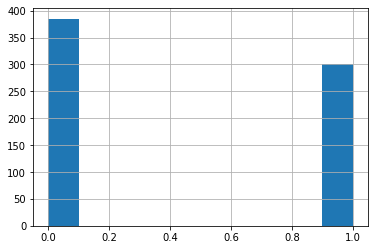

In [419]:
# check the distribution
X_train['class'].hist()

In [420]:
# assign the other half to test
X_test = banknotes[~banknotes.index.isin(list(X_train.index))]
X_test.sort_index()

,variance,skewness,curtosis,entropy,class,color
0,3.62160,8.66610,-2.80730,-0.44699,0,red
1,4.54590,8.16740,-2.45860,-1.46210,0,red
4,0.32924,-4.45520,4.57180,-0.98880,0,red
7,2.09220,-6.81000,8.46360,-0.60216,0,red
9,1.53560,9.17720,-2.27180,-0.73535,0,red
...,...,...,...,...,...,...
1366,-2.41000,3.74330,-0.40215,-1.29530,1,green
1367,0.40614,1.34920,-1.45010,-0.55949,1,green
1368,-1.38870,-4.87730,6.47740,0.34179,1,green
1370,-3.56370,-8.38270,12.39300,-1.28230,1,green


<AxesSubplot:>

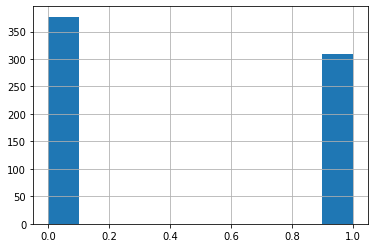

In [421]:
# check the distribution
X_test['class'].hist()

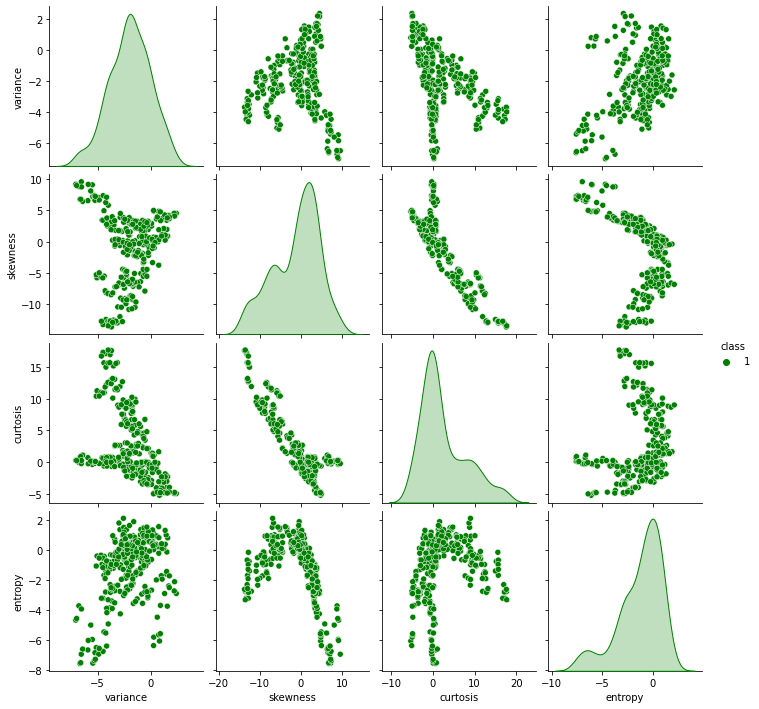

In [422]:
# authentic plot (green)
green_plot = sns.pairplot(X_train[X_train['class']==1], hue='class', palette={1:'green'})

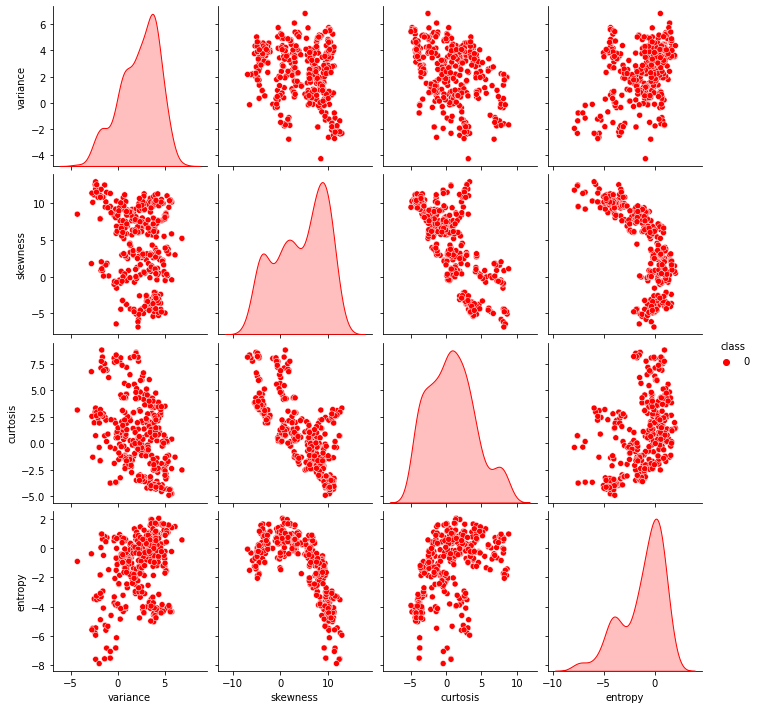

In [423]:
# fake notes plot (red)
red_plot = sns.pairplot(X_train[X_train['class']==0], hue='class', palette={0:'red'})

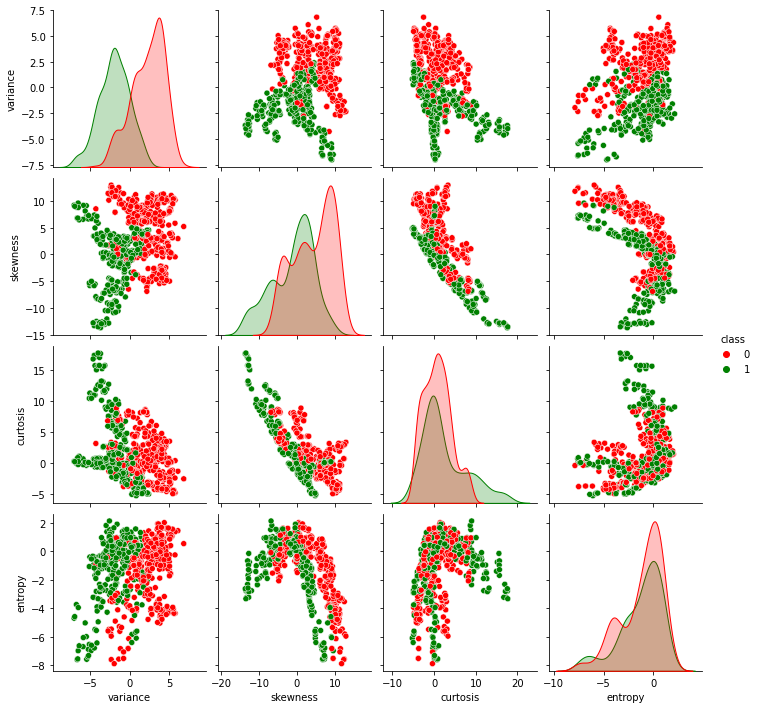

In [424]:
all_plot = sns.pairplot(X_train, hue="class", palette={0:'red',1:'green'})

### 2.2 Create a simple classifier
Use plot data to create three rules.

In [425]:
X_train.head(3)

,variance,skewness,curtosis,entropy,class,color
1240,-3.5510,1.8955,0.1865,-2.44090,1,green
703,1.3114,4.5462,2.2935,0.22541,0,red
821,-4.0173,-8.3123,12.4547,-1.43750,1,green


In [426]:
# simple classifier rules:
# variance < 0 , skewness < 5 and curtosis > 10
classifier = ((X_train['variance'] < 0) & (X_train['skewness'] < 5) & (X_train['curtosis'] >  10))

# predict the training labels based on simple classifier
X_train['pred_class'] = np.where(classifier, 1, 0)
X_train.head(3)

,variance,skewness,curtosis,entropy,class,color,pred_class
1240,-3.5510,1.8955,0.1865,-2.44090,1,green,0
703,1.3114,4.5462,2.2935,0.22541,0,red,0
821,-4.0173,-8.3123,12.4547,-1.43750,1,green,1


### 2.3 Apply the simple classifier to the test data

In [427]:
# simple classifier rules:
# variance < 0 , skewness < 5 and curtosis > 10
classifier = ((X_test['variance'] < 0) & (X_test['skewness'] < 5) & (X_test['curtosis'] >  10))

# predict the training labels based on simple classifier
X_test['pred_class'] = np.where(classifier, 1, 0)
X_test.head(3)

/var/folders/x9/2w_yb2vs3bd5qx2pdcj080dr0000gq/T/ipykernel_26430/736094521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred_class'] = np.where(classifier, 1, 0)


,variance,skewness,curtosis,entropy,class,color,pred_class
0,3.62160,8.6661,-2.8073,-0.44699,0,red,0
1,4.54590,8.1674,-2.4586,-1.46210,0,red,0
4,0.32924,-4.4552,4.5718,-0.98880,0,red,0


### 2.4 Compute model evaluation metrics

In [428]:
# true positives
true_pos = len(X_test.loc[((X_test['class'] == 1) & (X_test['pred_class'] == 1))])
true_pos

31

In [429]:
# true negatives
true_neg = len(X_test.loc[((X_test['class'] == 0) & (X_test['pred_class'] == 0))])
true_neg

377

In [430]:
# false positives
false_pos = len(X_test.loc[((X_test['class'] == 0) & (X_test['pred_class'] == 1))])
false_pos

0

In [431]:
# false negatives
false_neg = len(X_test.loc[((X_test['class'] == 1) & (X_test['pred_class'] == 0))])
false_neg

278

In [432]:
# true positive rate (sensitivity)
tpr = true_pos / (true_pos + false_neg)
tpr

0.10032362459546926

In [433]:
# true negative rate (specificity)
tnr = true_neg / (true_neg + false_pos)
tnr

1.0

In [434]:
# accuracy
acc = (true_pos + true_neg) / len(X_test)
acc

0.5947521865889213

#### 2.5 Create evaluation summary table

In [435]:
eval_data = {
    'tp':true_pos,
    'fp':false_pos,
    'tn':true_neg,
    'fn':false_neg,
    'accuracy':round(acc,2),
    'tpr':round(tpr,2),
    'tnr':tnr
}

eval_data

{'tp': 31,
 'fp': 0,
 'tn': 377,
 'fn': 278,
 'accuracy': 0.59,
 'tpr': 0.1,
 'tnr': 1.0}

In [436]:
eval_summary = pd.DataFrame([eval_data])
eval_summary.head()

,tp,fp,tn,fn,accuracy,tpr,tnr
0,31,0,377,278,0.59,0.1,1.0


### 2.6 Observations
Model gives higher accuracy on predicting negative values (100%) compared to positive values (10%). Model is 9% better than flipping a coin.

## 3. K-Nearest Neighbors

### 3.1

In [437]:
# convert data to numpy arrays
y_train_ = X_train.copy()['class'].to_numpy()
y_test_ = X_test.copy()['class'].to_numpy()

X_train_ = X_train.copy().drop(columns=['class','color','pred_class']).to_numpy()
X_test_ = X_test.copy().drop(columns=['class','color', 'pred_class']).to_numpy()


In [438]:
# scale features because we have a distance based algorithm
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_)
X_test_sc = scaler.transform(X_test_)


In [439]:
k_l = [3,5,7,9,11]
acc_l = []

for k in k_l:
    #print(k)
    classifier = KNeighborsClassifier(n_neighbors=k) 
    classifier.fit(X_train_sc,y_train_)
    y_pred =  classifier.predict(X_test_sc)
    cm = confusion_matrix(y_test_, y_pred)
    #print(cm)
    acc = accuracy_score(y_test_,y_pred)
    #print(acc)
    acc_l.append(acc)

In [440]:
k_results = pd.DataFrame(list(zip(k_l,acc_l)), columns=['k','accuracy'])
k_results

,k,accuracy
0,3,0.998542
1,5,0.998542
2,7,1.000000
3,9,0.989796
4,11,0.991254


### 3.2

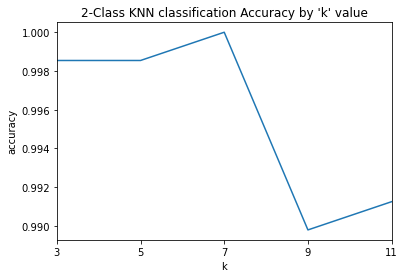

In [441]:
fig, ax = plt.subplots()

ax.plot(k_results.k, k_results.accuracy)
ax.set(xlim=(3,11), xticks=np.arange(3,13,2))
plt.title("2-Class KNN classification Accuracy by 'k' value")
plt.xlabel(k_results.columns[0])
plt.ylabel(k_results.columns[1])
plt.show()

k* = 7 

### 3.3

In [442]:
classifier = KNeighborsClassifier(n_neighbors=7) 
classifier.fit(X_train_sc,y_train_)
y_pred =  classifier.predict(X_test_sc)
cm = confusion_matrix(y_test_, y_pred)
#print(cm)
acc = accuracy_score(y_test_,y_pred)
#print(acc)
acc_l.append(acc)

In [443]:
cm

array([[377,   0],
       [  0, 309]])

In [444]:
# true positives
true_pos = cm[1][1]
true_pos

309

In [445]:
# true negatives
true_neg = cm[0][0]
true_neg

377

In [446]:
# false positives
false_pos = cm[0][1]
false_pos

0

In [447]:
# false negatives
false_neg = cm[1][0]
false_neg

0

In [448]:
# true positive rate (sensitivity)
tpr = true_pos / (true_pos + false_neg)
tpr

1.0

In [449]:
# true negative rate (specificity)
tnr = true_neg / (true_neg + false_pos)
tnr

1.0

In [450]:
# accuracy
acc = (true_pos + true_neg) / len(X_test_)
acc

1.0

In [451]:
eval_data = {
    'tp':true_pos,
    'fp':false_pos,
    'tn':true_neg,
    'fn':false_neg,
    'accuracy':round(acc,2),
    'tpr':round(tpr,2),
    'tnr':tnr
}

eval_data

{'tp': 309,
 'fp': 0,
 'tn': 377,
 'fn': 0,
 'accuracy': 1.0,
 'tpr': 1.0,
 'tnr': 1.0}

In [452]:
eval_summary = pd.DataFrame([eval_data])
eval_summary.head()

,tp,fp,tn,fn,accuracy,tpr,tnr
0,309,0,377,0,1.0,1.0,1.0


### 3.4

The KNN classifier is much better than the simple classifier (100%) vs. 59%, however, this model may be extremely biased based on these results.

### 3.5
BUID - 2647

Simple Classifier prediction

In [464]:
buid = pd.DataFrame([[2,6,4,7]], columns = ['variance','skewness','curtosis','entropy'])
buid.head()


,variance,skewness,curtosis,entropy
0,2,6,4,7


In [465]:
# simple classifier
# variance < 0 , skewness < 5 and curtosis > 10
classifier = ((buid['variance'] < 0) & (buid['skewness'] < 5) & (buid['curtosis'] >  10))

# predict the training labels based on simple classifier
buid['pred_class'] = np.where(classifier, 1, 0)
buid.head(3)

,variance,skewness,curtosis,entropy,pred_class
0,2,6,4,7,0


The simple classifier would predict that the banknote is fake.

KNN (k=7) prediction

In [474]:
# KNN classifier
classifier = KNeighborsClassifier(n_neighbors=7) 
classifier.fit(X_train_sc,y_train_)

buid_pred = classifier.predict(buid.drop(columns='pred_class').to_numpy())
buid_pred

array([0])

The KNN model would predict that the banknote is fake.

## 4. Feature Selection (KNN)

### 4.1

In [482]:
X_train.head(0)

,variance,skewness,curtosis,entropy,class,color,pred_class


In [496]:
def knn_predictor(k, x_train, x_test, y_train, y_test):
    """ 
    predicts a class using k-nearest neighbors model
    """

    # scale features because we have a distance based algorithm
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(x_train)
    X_test_sc = scaler.transform(x_test)

    classifier = KNeighborsClassifier(n_neighbors=k) 
    classifier.fit(X_train_sc,case1_y_train)
    
    y_pred =  classifier.predict(X_test_sc)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n {}".format(cm))

    acc = accuracy_score(y_test,y_pred)
    print("Accuracy:", round(acc,3))

    return y_pred, cm, acc

Case 1 - drop variance

In [481]:
# convert data to numpy arrays
case1_y_train = X_train.copy()['class'].to_numpy()
case1_y_test = X_test.copy()['class'].to_numpy()

# drop variance
case1_X_train = X_train.drop(columns=['variance', 'class','pred_class', 'color'])
case1_X_test = X_test.drop(columns=['variance','class','pred_class', 'color'])

In [497]:
y_pred, cm, acc = knn_predictor(7, case1_X_train, case1_X_test, case1_y_train, case1_y_test)

Confusion Matrix:
 [[360  17]
 [ 22 287]]
Accuracy: 0.943


Case 2 - drop skewness

In [499]:
# convert data to numpy arrays
case2_y_train = X_train.copy()['class'].to_numpy()
case2_y_test = X_test.copy()['class'].to_numpy()

# drop variance
case2_X_train = X_train.drop(columns=['skewness', 'class','pred_class', 'color'])
case2_X_test = X_test.drop(columns=['skewness','class','pred_class', 'color'])

In [500]:
y_pred, cm, acc = knn_predictor(7, case2_X_train, case2_X_test, case2_y_train, case2_y_test)

Confusion Matrix:
 [[366  11]
 [  6 303]]
Accuracy: 0.975


Case 3 - drop curtosis

In [501]:
# convert data to numpy arrays
case3_y_train = X_train.copy()['class'].to_numpy()
case3_y_test = X_test.copy()['class'].to_numpy()

# drop variance
case3_X_train = X_train.drop(columns=['curtosis', 'class','pred_class', 'color'])
case3_X_test = X_test.drop(columns=['curtosis','class','pred_class', 'color'])

In [502]:
y_pred, cm, acc = knn_predictor(7, case3_X_train, case3_X_test, case3_y_train, case3_y_test)

Confusion Matrix:
 [[369   8]
 [  5 304]]
Accuracy: 0.981


Case 4 - drop entropy

In [503]:
# convert data to numpy arrays
case4_y_train = X_train.copy()['class'].to_numpy()
case4_y_test = X_test.copy()['class'].to_numpy()

# drop variance
case4_X_train = X_train.drop(columns=['entropy', 'class','pred_class', 'color'])
case4_X_test = X_test.drop(columns=['entropy','class','pred_class', 'color'])

In [504]:
y_pred, cm, acc = knn_predictor(7, case4_X_train, case4_X_test, case4_y_train, case4_y_test)

Confusion Matrix:
 [[375   2]
 [  0 309]]
Accuracy: 0.997


### 4.2

Results: 
* Case 1 (drop variance) Accuracy: 94.3%
* Case 2 (dro skewness) Accuracy: 97.5%
* Case 3 (drop curtosis) Accuracy: 98.1%
* Case 4 (drop entropy) Accuracy: 99.7%

It was impossible to increase the accuracy of the optimal k value (k* = 7, 100% accuracy), however, dropping entropy resulted in better accuracy than any of the other k values. 

### 4.3

Dropping variance contributed to the largest accuracy drop.

### 4.4

Dropping entropy contributed to the most improvement in accuracy (excluding k* = 7).

## 5. Logistic Regression

### 5.1 Logistic Regression Classifier

In [514]:
def logreg_predictor(x_train, x_test, y_train, y_test):
    """ 
    predicts a class using logistic regression model
    """

    classifier = LogisticRegression()
    classifier.fit(x_train, y_train)
    
    y_pred =  classifier.predict(x_test)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n {}".format(cm))

    acc = accuracy_score(y_test,y_pred)
    print("Accuracy:", round(acc,3))

    return y_pred, cm, acc

In [515]:
y_pred, cm, acc = logreg_predictor(X_train_, X_test_, y_train_, y_test_)

Confusion Matrix:
 [[371   6]
 [  0 309]]
Accuracy: 0.991


### 5.2 Model Evaluation

In [516]:
# true positives
true_pos = cm[1][1]
true_pos

309

In [517]:
# true negatives
true_neg = cm[0][0]
true_neg

371

In [518]:
# false positives
false_pos = cm[0][1]
false_pos

6

In [519]:
# false negatives
false_neg = cm[1][0]
false_neg

0

In [520]:
# true positive rate (sensitivity)
tpr = true_pos / (true_pos + false_neg)
tpr

1.0

In [521]:
# true negative rate (specificity)
tnr = true_neg / (true_neg + false_pos)
tnr

0.9840848806366048

In [522]:
# accuracy
acc = (true_pos + true_neg) / len(X_test_)
acc

0.9912536443148688

In [535]:
eval_data = {
    'tp':true_pos,
    'fp':false_pos,
    'tn':true_neg,
    'fn':false_neg,
    'accuracy':round(acc,3),
    'tpr':round(tpr,2),
    'tnr':tnr
}

eval_data

{'tp': 309,
 'fp': 6,
 'tn': 371,
 'fn': 0,
 'accuracy': 0.991,
 'tpr': 1.0,
 'tnr': 0.9840848806366048}

In [536]:
eval_summary = pd.DataFrame([eval_data])
eval_summary.head()

,tp,fp,tn,fn,accuracy,tpr,tnr
0,309,6,371,0,0.991,1.0,0.984085


### 5.3
Logistic Regression model had a higher TPR (100% v. 10%) and overall accuracy score (99% vs. 59%) compared to the simple classifier model.

### 5.4
Logistic Regression model had equal  TPR (100%) compared to the KNN model, but lower TNR (98% v. 100%) and overally accuracy (99% v. 100%) compared to the KNN model.

### 5.5 BUID

In [525]:
buid

,variance,skewness,curtosis,entropy,pred_class
0,2,6,4,7,0


In [526]:
# LogReg Classifier
classifier = LogisticRegression()
classifier.fit(X_train_, y_train_)

buid_pred = classifier.predict(buid.drop(columns='pred_class').to_numpy())
buid_pred

array([0])

The LogReg classifier predicts that a banknote ending that shares the last 4 digits with the last 4 digits of my BUID would be a fake.

## 6. Feature Selection (LogReg)

### 6.1

In [ ]:
X_train.head(0)

,variance,skewness,curtosis,entropy,class,color,pred_class


Case 1 - drop variance

In [527]:
y_pred, cm, acc = logreg_predictor(case1_X_train, case1_X_test, case1_y_train, case1_y_test)

Confusion Matrix:
 [[308  69]
 [ 56 253]]
Accuracy: 0.818


Case 2 - drop skewness

In [530]:
y_pred, cm, acc = logreg_predictor(case2_X_train, case2_X_test, case2_y_train, case2_y_test)

Confusion Matrix:
 [[354  23]
 [ 35 274]]
Accuracy: 0.915


Case 3 - drop curtosis

In [532]:
y_pred, cm, acc = logreg_predictor(case3_X_train, case3_X_test, case3_y_train, case3_y_test)

Confusion Matrix:
 [[343  34]
 [ 57 252]]
Accuracy: 0.867


Case 4 - drop entropy

In [534]:
y_pred, cm, acc = logreg_predictor(case4_X_train, case4_X_test, case4_y_train, case4_y_test)

Confusion Matrix:
 [[371   6]
 [  0 309]]
Accuracy: 0.991


### 6.2

Results: 
* All features Accuracy: 99.1%
* Case 1 (drop variance) Accuracy: 81.8%
* Case 2 (dro skewness) Accuracy: 91.5%
* Case 3 (drop curtosis) Accuracy: 86.7%
* Case 4 (drop entropy) Accuracy: 99.1%

Dropping these features did not improve the accuracy - dropping entropy matched the accuracy of all four features (99%).

### 6.3

Dropping variance contributed to the largest accuracy drop.

### 6.4

Dropping entropy contributed to the most improvement in accuracy.

#### 6.5
The relative significance of features is the same across models (which is interesting).